In [142]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
import pandas as pd
import numpy as np

from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


import matplotlib.pyplot as plt


from helpers import read_data
from helpers import select_data_interval
from helpers import get_entry_points
from helpers import get_peaks
from helpers import get_strokes
from helpers import get_exit_and_air_points
from helpers import indicators_calculator
from helpers import strokes_indicators
from helpers import delete_points_before_first_entry

from bokeh.plotting import figure
# Make Bokeh Push push output to Jupyter Notebook.
from bokeh.io import output_notebook




output_notebook()

plt.style.use(['science', 'notebook', 'grid'])

Loading BokehJS ...

In [144]:
all_data = read_data("data/serie1.csv")

In [156]:
all_data.head()

,gx,gy,gz,ax,ay,az,roll,pitch,yaw,time_stamp,VideoRecord,DataRecord,time
0,-0.230923,-0.207441,9.775241,0.009762,-0.037026,-0.116692,-1.215694,1.352960,-75.617987,2021-04-14 09:36:23.798803534,0,0,0.000000
1,-0.231059,-0.206907,9.775246,-0.011849,-0.038299,-0.082622,-1.212565,1.353756,-75.623602,2021-04-14 09:36:23.804777606,0,0,0.005974
2,-0.231120,-0.206342,9.775259,0.035373,-0.046901,-0.106915,-1.209251,1.354111,-75.628171,2021-04-14 09:36:23.816774416,0,0,0.017971
3,-0.231410,-0.205629,9.775267,0.018524,-0.019500,-0.102143,-1.205073,1.355812,-75.633929,2021-04-14 09:36:23.828785041,0,0,0.029982
4,-0.231628,-0.205070,9.775270,0.047111,-0.021787,-0.118483,-1.201798,1.357087,-75.640288,2021-04-14 09:36:23.834772020,0,0,0.035968


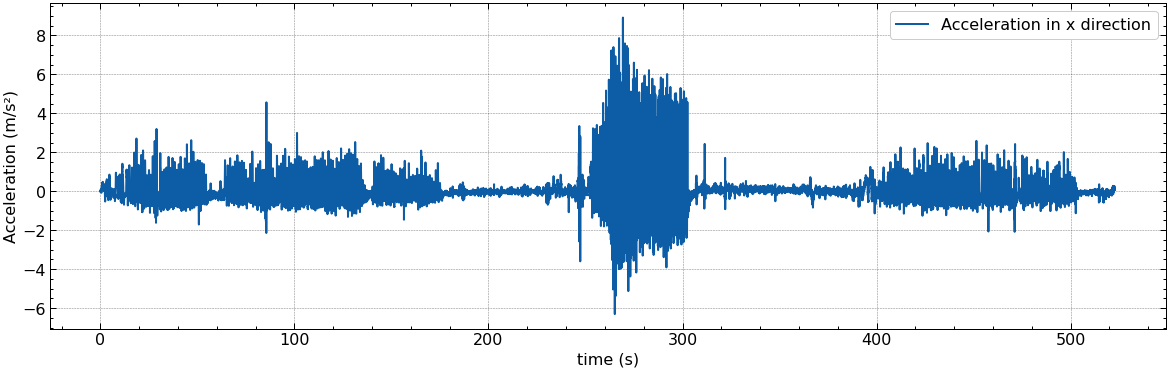

In [145]:
plt.figure(figsize=(20, 6))
#plt.scatter(entry['time'], entry.ax, label=r'Entry', color='red', lw=3)
plt.plot(all_data['time'], all_data.ax, label=r'Acceleration in x direction')
plt.xlabel('time (s)')
plt.ylabel(r'Acceleration (m/s²)')
plt.legend()
plt.show()

Neste grafico podemos ver que o exercicio começou por volta dos 260 segundos e durou ate aos 302

In [175]:
data = select_data_interval(all_data, start=271, end=273.2)

entries = get_entry_points(data)
peaks = get_peaks(data)
exits, air_fase = get_exit_and_air_points(data)
strokes = get_strokes(data)

strokes, entries, peaks, exits, air_fase = delete_points_before_first_entry(
        strokes, entries, peaks, exits, air_fase)

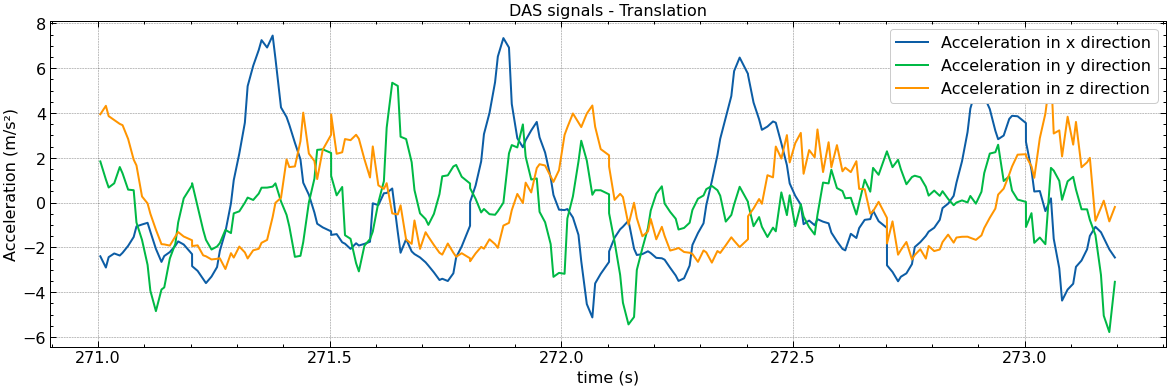

In [176]:
plt.figure(figsize=(20, 6))
#plt.scatter(entry['time'], entry.ax, label=r'Entry', color='red', lw=3)
plt.plot(data['time'], data.ax, label=r'Acceleration in x direction')
plt.plot(data['time'], data.ay, label=r'Acceleration in y direction')#, alpha=0.6)
plt.plot(data['time'], data.az, label=r'Acceleration in z direction')#, alpha=0.3)
plt.xlabel('time (s)')
plt.ylabel(r'Acceleration (m/s²)')
plt.title('DAS signals - Translation')
plt.legend()
plt.savefig('das_signal_translation.jpeg')
plt.show()


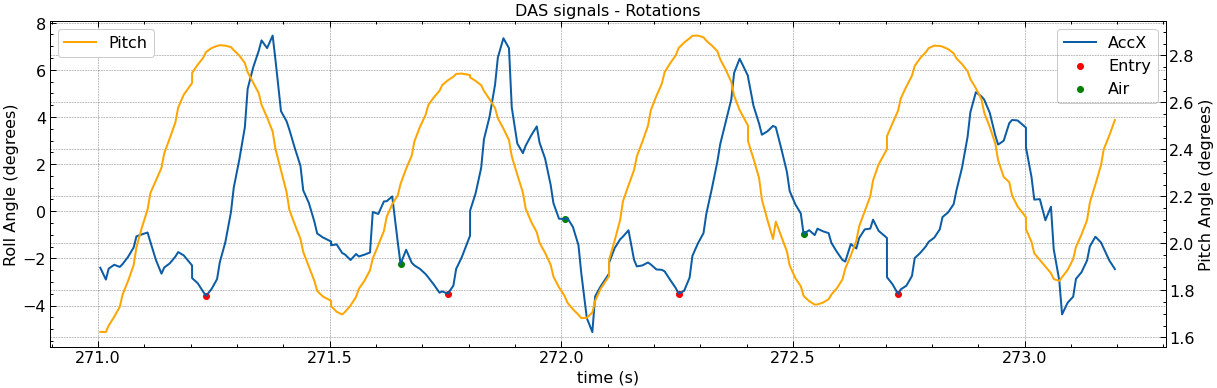

In [183]:
# plt.figure(figsize=(20, 6))
# #plt.scatter(entry['time'], entry.ax, label=r'Entry', color='red', lw=3)
# plt.plot(all_data['time'], all_data.roll, label=r'Roll')
# plt.plot(all_data['time'], all_data.pitch, label=r'Pitch')
# #plt.plot(all_data['time'], all_data.yaw, label=r'Yaw')
# plt.xlabel('time (s)')
# plt.ylabel(r'Angle (degrees)')
# plt.title('DAS signals - Rotations')
# plt.legend()
# plt.savefig('das_signal_rotations.jpeg')
# plt.show()


# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(20, 6))
# make a plot
ax.plot(data['time'], data.ax, label=r'AccX')
ax.scatter(entries['time'], entries.ax, label=r'Entry', color='red')
ax.scatter(air_fase['time'], air_fase.ax, label=r'Air', color='green')
# set x-axis label
ax.set_xlabel("time (s)")
# set y-axis label
ax.set_ylabel(r'Roll Angle (degrees)')
ax.legend()
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data['time'], data.pitch, label=r'Pitch', color="orange")
ax2.set_ylabel(r'Pitch Angle (degrees)')
ax2.legend(loc="upper left")
plt.title('DAS signals - Rotations')
# plt.legend()
# plt.savefig('das_signal_rotations.jpeg')
#plt.savefig('das_signal_rotations.jpeg')
plt.show()



In [147]:
p = figure(title="AccZ", x_axis_label='time', y_axis_label='Acceleration', height = 200)

# Add a line renderer with legend and line thickness
p.line(data.time,data.ax, legend="AccZ", color='red')
p.circle(entries.time, entries.ax, legend='Entry', color='green')
p.circle(peaks.time, peaks.ax, legend='Peaks', color='black')
p.circle(exits.time, exits.ax, legend='Exit', color='violet')
p.circle(air_fase.time, air_fase.ax, legend='air_fase', color='orange')
p.legend.click_policy="hide"
p.sizing_mode = "scale_width"
# Show the results
show(p)

In [148]:
indicatos = strokes_indicators(data)
indicatos#['Useful Force - Pull Fase']

AAA


,Speed Variation - Entry Fase,Pitch Amplitude - Entry Fase,Mean Acceleration - Entry Fase,Min Acceleration - Entry Fase,Max Acceleration - Entry Fase,Mean Pitch - Entry Fase,Useful Force - Entry Fase,Speed Variation - Pull Fase,Pitch Amplitude - Pull Fase,Mean Acceleration - Pull Fase,...,Pitch Amplitude - Water Fase,Mean Acceleration - Water Fase,Min Acceleration - Water Fase,Max Acceleration - Water Fase,Mean Pitch - Water Fase,Useful Force - Water Fase,Water Time,Air Time,Stroke Rate,Stroke Time
0,0.109638,0.344256,0.648852,-1.528686,5.165021,1.985458,50.496875,0.432427,0.370791,2.682119,...,0.731530,1.246971,-1.528686,5.165021,2.239320,24.626801,0.402049,0.408058,74.064263,0.810107
1,0.224824,0.273303,1.985621,-0.442756,4.297853,1.735663,0.308947,0.311760,0.529819,2.313523,...,0.906880,1.518954,-1.048413,4.297853,2.083011,0.995991,0.312043,0.348053,90.895951,0.660095
2,0.091460,0.125908,0.676796,-1.608141,5.725502,1.872138,-1.156161,0.503761,0.740397,2.649657,...,0.893244,1.525506,-1.608141,5.725502,2.127235,-0.843954,0.372054,0.360054,81.955176,0.732108
3,0.203782,0.138003,1.940720,-1.408078,5.628230,1.587328,0.971738,0.529660,1.003289,2.974101,...,1.163601,2.131980,-1.565343,5.628230,1.951072,0.855090,0.312045,0.276045,102.025195,0.588090
4,0.100290,0.446861,0.945662,-2.709570,7.224815,2.049317,0.739053,0.702076,0.947195,2.981527,...,1.004967,2.106056,-2.709570,7.224815,2.080886,0.633545,0.360048,0.210030,105.248886,0.570077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,-0.011389,0.751768,0.179663,-2.373397,5.297803,2.694623,8.246997,0.374765,0.382595,2.980753,...,1.134363,1.187772,-2.373397,5.297803,2.378967,4.950927,0.288036,0.318048,98.996042,0.606085
71,0.123664,0.762854,1.180698,-2.734914,4.549422,2.401101,2.087016,0.276086,0.282650,1.792023,...,1.045504,1.224379,-2.734914,4.549422,2.063632,1.283770,0.294036,0.276041,105.248916,0.570077
72,0.213423,0.901954,1.376126,-2.324090,4.697205,2.406665,0.486077,0.045649,0.822103,0.251924,...,1.040816,0.521814,-2.324090,4.697205,2.249667,0.110736,0.444064,0.138031,103.075989,0.582095
73,0.152313,0.593019,1.037430,-2.606029,5.126968,2.330380,0.986735,0.115558,0.731638,0.588850,...,0.881880,0.472630,-2.606029,5.126968,2.117718,0.201773,0.432057,0.138024,105.248103,0.570082


In [149]:
indicatos.isna().any(axis=0)

Speed Variation - Entry Fase      False
Pitch Amplitude - Entry Fase      False
Mean Acceleration - Entry Fase    False
Min Acceleration - Entry Fase     False
Max Acceleration - Entry Fase     False
Mean Pitch - Entry Fase           False
Useful Force - Entry Fase         False
Speed Variation - Pull Fase       False
Pitch Amplitude - Pull Fase       False
Mean Acceleration - Pull Fase     False
Min Acceleration - Pull Fase      False
Max Acceleration - Pull Fase      False
Mean Pitch - Pull Fase            False
Useful Force - Pull Fase          False
Speed Variation - Exit Fase       False
Pitch Amplitude - Exit Fase       False
Mean Acceleration - Exit Fase     False
Min Acceleration - Exit Fase      False
Max Acceleration - Exit Fase      False
Mean Pitch - Exit Fase            False
Useful Force - Exit Fase          False
Speed Variation - Air Fase        False
Pitch Amplitude - Air Fase        False
Mean Acceleration - Air Fase      False
Min Acceleration - Air Fase       False


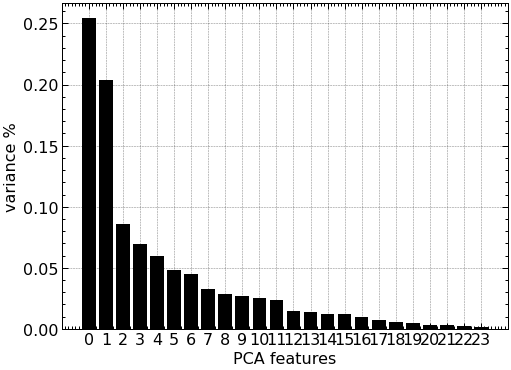

In [150]:
X_std = StandardScaler().fit_transform(indicatos)# Create a PCA instance: pca
pca = PCA(n_components=24)
principalComponents = pca.fit_transform(X_std)# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

Text(0, 0.5, 'PCA 2')

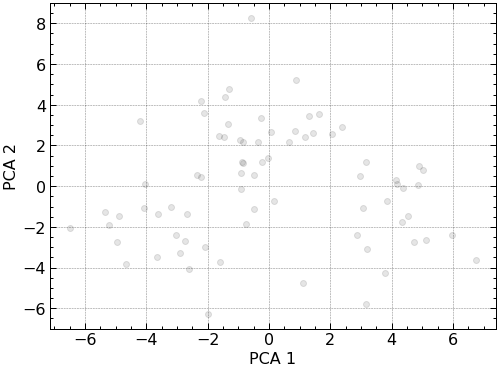

In [151]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

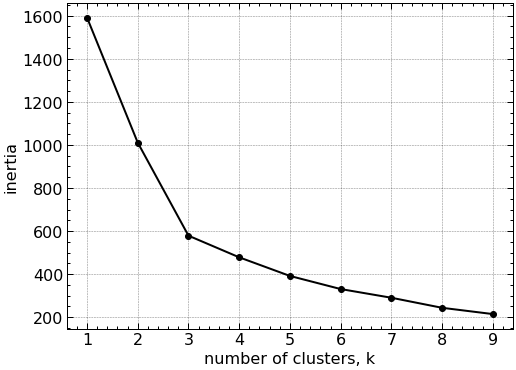

In [152]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [153]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)

kmeans.fit(PCA_components)

KMeans(init='random', n_clusters=3, random_state=42)

In [154]:
for stroke, label in zip(strokes, kmeans.labels_):
    stroke['label'] = [label for _ in range(len(stroke))]

In [155]:
p = figure(title="AccX", x_axis_label='time', y_axis_label='Acceleration', height = 200)

# Add a line renderer with legend and line thickness
p.line(data.time,data.ax, legend="AccX", color='black')
for stroke in strokes[1:]:
    if stroke.label.iloc[0] == 0:
        color = 'red'
    elif stroke.label.iloc[0] == 1:
        color = 'green'
    elif stroke.label.iloc[0] == 2:
        color = 'orange'
        
    p.circle(stroke.time, stroke.ax, color=color)
p.legend.click_policy="hide"
p.sizing_mode = "scale_width"
# Show the results
show(p)

In [ ]:
<script src="https://gist.github.com/tiagoportelanelo/056208599a145077c995e9387c6aac85.js"></script>